In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Practice 4M1

In [2]:
_size=int(1e6)
mu = np.random.normal(loc=0, scale=10, size=_size)
sigma = np.random.uniform(0,10, size=_size)
y = np.random.normal(loc=mu, scale=sigma, size=_size)

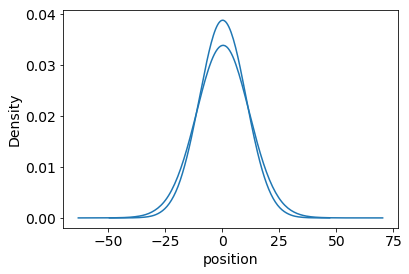

In [3]:
pm.kdeplot(mu)
plt.xlabel('position', fontsize=14)
plt.ylabel('Density', fontsize=14);

pm.kdeplot(y)
plt.xlabel('position', fontsize=14)
plt.ylabel('Density', fontsize=14);

Practice 4H1

In [4]:
d = pd.read_csv('Data/Howell1.csv', sep=';', header=0)

In [5]:
d['weight_std'] = (d.weight - d.weight.mean()) / d.weight.std()
d['weight_std2'] = d['weight_std']**2

In [6]:
d.head()

,height,weight,age,male,weight_std,weight_std2
0,151.765,47.825606,63.0,1,0.829869,0.688682
1,139.700,36.485807,63.0,0,0.059459,0.003535
2,136.525,31.864838,65.0,0,-0.254483,0.064762
3,156.845,53.041915,41.0,1,1.184257,1.402466
4,145.415,41.276872,51.0,0,0.384957,0.148192


In [7]:
with pm.Model() as second_order_model:
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Deterministic('mu', alpha + beta[0] * d.weight_std + beta[1] * d.weight_std2)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d.height)
    trace = pm.sample(10000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:19<00:00, 1130.85draws/s]


/home/rer/anaconda3/envs/pymc3_resources/lib/python3.7/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


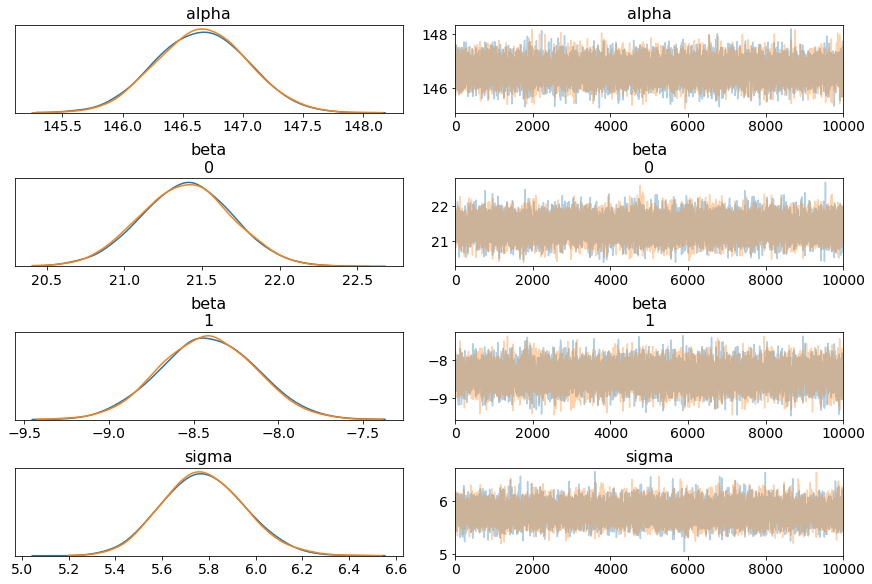

In [8]:
varnames = ['alpha', 'beta', 'sigma']
pm.traceplot(trace, varnames);

chain_N = trace[1000:]

In [9]:
pm.summary(chain_N, varnames, alpha=.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
alpha,146.66,0.38,0.0,146.05,147.25,11667.79,1.0
beta__0,21.40,0.29,0.0,20.93,21.87,12666.60,1.0
beta__1,-8.42,0.28,0.0,-8.87,-7.97,11072.24,1.0
sigma,5.78,0.17,0.0,5.48,6.03,13456.76,1.0


In [10]:
new_weights = [46.95, 43.72, 64.78, 32.59, 54.63]

In [11]:
new_weights_std = (new_weights - d.weight.mean()) / d.weight.std()

In [12]:
new_weights_std2 = new_weights_std**2

In [13]:
new_preds = chain_N['alpha'].mean() + chain_N['beta'][:,0].mean() * new_weights_std + chain_N['beta'][:,1].mean() * new_weights_std2
index = [1,2,3,4,5]
columns=['weight', 'exp_height']
df = pd.DataFrame(index=index, columns=columns)

In [14]:
df['weight']=new_weights
df['exp_height']=new_preds
df['weight_std']=new_weights_std
df['weight_std2']=new_weights_std2

In [15]:
df

,weight,exp_height,weight_std,weight_std2
1,46.95,158.153634,0.770381,0.593488
2,43.72,155.897672,0.550940,0.303535
3,64.78,156.021725,1.981726,3.927239
4,32.59,141.916072,-0.205216,0.042114
5,54.63,160.263144,1.292150,1.669651


Note that individual 3 is so heavy that he is at the extreme end of the data, at a position where (using the second order model) the quadratic shape has started to decrease, hence their expected height is lower than the lighter individual 1.

In [16]:
mu_pred = trace['mu']
idx = np.argsort(d.weight_std)
mu_hpd = pm.hpd(mu_pred, alpha=.11)[idx]

height_pred = pm.sample_posterior_predictive(trace, 200, second_order_model)
height_pred_hpd = pm.hpd(height_pred['height'], alpha=.11)[idx]

100%|██████████| 200/200 [00:00<00:00, 1210.99it/s]


In [17]:
d['hpd_height_low'] = pm.hpd(height_pred['height'], alpha=.11)[:,0]
d['hpd_height_high'] = pm.hpd(height_pred['height'], alpha=.11)[:,1]

In [18]:
delta = 0.1
tup = [1,2,4,5]

relevant_rows = []

for i in tup:
    _weight = df['weight'][i]
    relevant_rows.append(d[(d['weight'] >= _weight - delta) & (d['weight'] <= _weight + delta)].index[0])
    #print(d[(d['weight'] >= _weight - delta) & (d['weight'] <= _weight + delta)].index)
    
_weight = df['weight'][5]
relevant_rows.append(d[(d['weight'] >= _weight - delta) & (d['weight'] <= _weight + delta)].index[1])

delta = 2
_weight = df['weight'][3]
relevant_rows.insert(2,(d[(d['weight'] >= _weight - delta) & (d['weight'] <= _weight + delta)].index[0]))
    

In [19]:
df2 = pd.DataFrame(d, index=relevant_rows)

In [20]:
df2

,height,weight,age,male,weight_std,weight_std2,hpd_height_low,hpd_height_high
534,162.5600,47.031821,27.0,0,0.775940,0.602083,151.701674,168.936018
426,151.9428,43.714929,21.0,1,0.550595,0.303155,146.854813,165.026743
5,163.8300,62.992589,35.0,1,1.860292,3.460687,147.481012,164.882898
496,144.7800,32.545226,15.0,0,-0.208258,0.043372,133.750997,150.592547
217,168.2750,54.600000,41.0,1,1.290112,1.664388,151.078538,169.573152
321,160.0200,54.601137,28.0,0,1.290189,1.664587,150.224043,170.775669


The elements in this dataframe have weights very similar to the specific ones in our sample.  The hpd has been estimated by the pymc3 sample posterior prediction.  We can therefore presume that the hpds will be similar to the individuals in our specific sample.  Note the last two elements have the similar weights, similar hpds but quite different heights (and gender).  Adding information about the gender to the linear model would allow us to model the hpds even more realistically.

Another way we can do this is by using the multiple samplings of the parameters in chain_N (i.e. the trace), which we replicate here below.

In [21]:
new_preds_height = []
hpd_height_low = []
hpd_height_high = []

for i in range(len(new_weights_std)):
    new_preds_height.append(chain_N['alpha'] + chain_N['beta'][:,0] * new_weights_std[i] + chain_N['beta'][:,1] * new_weights_std2[i] + np.random.normal(loc=0,scale=chain_N['sigma']))
    hpd_height_low.append(pm.hpd(new_preds_height[i], alpha=.11)[0])
    hpd_height_high.append(pm.hpd(new_preds_height[i], alpha=.11)[1])

In [22]:
df['hpd_height_low'] = hpd_height_low
df['hpd_height_high'] = hpd_height_high

In [23]:
df

,weight,exp_height,weight_std,weight_std2,hpd_height_low,hpd_height_high
1,46.95,158.153634,0.770381,0.593488,148.829730,167.293002
2,43.72,155.897672,0.550940,0.303535,146.865270,165.280948
3,64.78,156.021725,1.981726,3.927239,146.602150,165.590707
4,32.59,141.916072,-0.205216,0.042114,132.551921,151.210408
5,54.63,160.263144,1.292150,1.669651,150.621816,169.194988


Again, we can see the outlier large weight of 64.78kg for individual 3 suffers from being so large that the quadratic functional fit has started to decline.  The prediction is therefore that this individual is shorter than the individuals (1 and 2) of lighter weight (46.95 and 43.95kg).

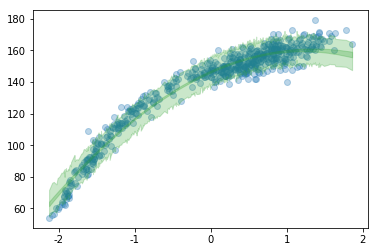

In [24]:
plt.scatter(d.weight_std, d.height, c='C0', alpha=0.3)
plt.fill_between(d.weight_std[idx], mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.25);
plt.fill_between(d.weight_std[idx], height_pred_hpd[:,0], height_pred_hpd[:,1], color='C2', alpha=0.25)

at = np.arange(-2, 3)
plt.xticks(at, at);

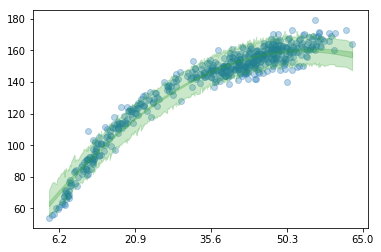

In [25]:
plt.scatter(d.weight_std, d.height, c='C0', alpha=0.3)
plt.fill_between(d.weight_std[idx], mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.25);
plt.fill_between(d.weight_std[idx], height_pred_hpd[:,0], height_pred_hpd[:,1], color='C2', alpha=0.25)

at = np.arange(-2, 3)
plt.xticks(at, np.round(at * d.weight.std() + d.weight.mean(), 1));

4H2

In [26]:
d = pd.read_csv('Data/Howell1.csv', sep=';', header=0)

In [27]:
dfUnder18 = d[d['age'] < 18]

In [28]:
len(dfUnder18)

192

In [29]:
with pm.Model() as u18model:
    alpha = pm.Normal('alpha', mu=110, sd=30)
    beta = pm.Lognormal('beta', mu=0, sd=10)
    sigma = pm.Uniform('sigma', 0, 50)
    mu = pm.Deterministic('mu', alpha + beta * (dfUnder18.weight - dfUnder18.weight.mean()))
    height = pm.Normal('height', mu=mu, sd=sigma, observed=dfUnder18.height)
    traceU18 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1571.66draws/s]


/home/rer/anaconda3/envs/pymc3_resources/lib/python3.7/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


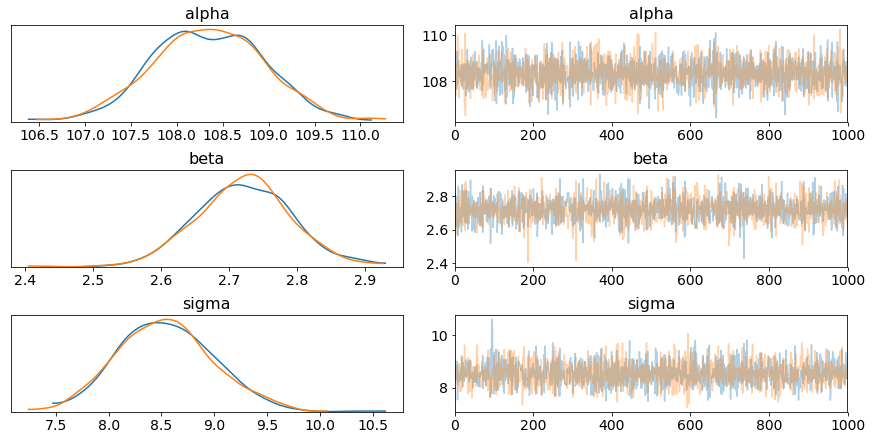

In [30]:
varnames = ['alpha', 'beta', 'sigma']
pm.traceplot(traceU18, varnames);

chainU18 = traceU18[100:]

In [31]:
map = pm.find_MAP(model=u18model)
#print(map['mu'])

/home/rer/anaconda3/envs/pymc3_resources/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -694.48, ||grad|| = 18.258: 100%|██████████| 27/27 [00:00<00:00, 508.65it/s]  


In [32]:
weight_seq = np.arange(round(dfUnder18.weight.min()), dfUnder18.weight.max()+1)
# Given- that we have a lot of samples we can use less of them for plotting (or we can use all!)
#chain_N_thinned = chainU18[::10]
chain_N_thinned = chainU18
mu_pred = np.zeros((len(weight_seq), len(chain_N_thinned)*chainU18.nchains))
for i, w in enumerate(weight_seq):
    mu_pred[i] = chain_N_thinned['alpha'] + chain_N_thinned['beta'] * (w - dfUnder18.weight.mean())

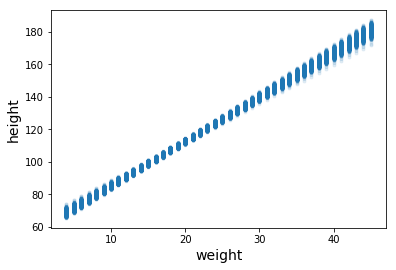

In [33]:
plt.plot(weight_seq, mu_pred, 'C0.', alpha=0.1)
plt.xlabel('weight', fontsize=14)
plt.ylabel('height', fontsize=14);

In [34]:
#mu_mean = mu_pred.mean(1)
mu_hpd = pm.hpd(mu_pred.T, alpha=.11)

In [35]:
#height_pred = pm.sample_ppc(chain_N, num, m_N)
height_pred = pm.sample_posterior_predictive(chainU18, 200, u18model)
height_pred_hpd = pm.hpd(height_pred['height'])

100%|██████████| 200/200 [00:00<00:00, 1199.99it/s]


In [36]:
idx = np.argsort(dfUnder18.weight.values[:])
dfUnder18_weight_ord = dfUnder18.weight.values[:][idx]
height_pred_hpd = height_pred_hpd[idx]

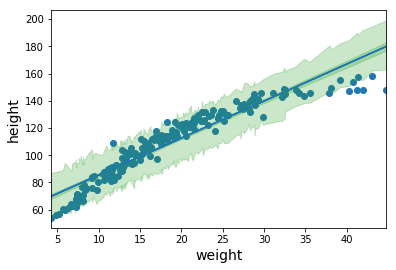

In [37]:
plt.scatter(dfUnder18.weight[:], dfUnder18.height[:])
plt.fill_between(weight_seq, mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.25)
#plt.plot(weight_seq, mu_mean, 'C2')
plt.plot(dfUnder18.weight, map['mu'])
plt.fill_between(dfUnder18_weight_ord, height_pred_hpd[:,0], height_pred_hpd[:,1], color='C2', alpha=0.25)
plt.xlabel('weight', fontsize=14)
plt.ylabel('height', fontsize=14)
plt.xlim(dfUnder18.weight[:].min(), dfUnder18.weight[:].max());

4H3

In [38]:
d = pd.read_csv('Data/Howell1.csv', sep=';', header=0)

In [39]:
with pm.Model() as logModel:
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=100)
    sigma = pm.Uniform('sigma', 0, 50)
    mu = pm.Deterministic('mu', alpha + beta * np.log2(d.weight))
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d.height)
    traceLog = pm.sample(1000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:11<00:00, 516.44draws/s]


/home/rer/anaconda3/envs/pymc3_resources/lib/python3.7/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


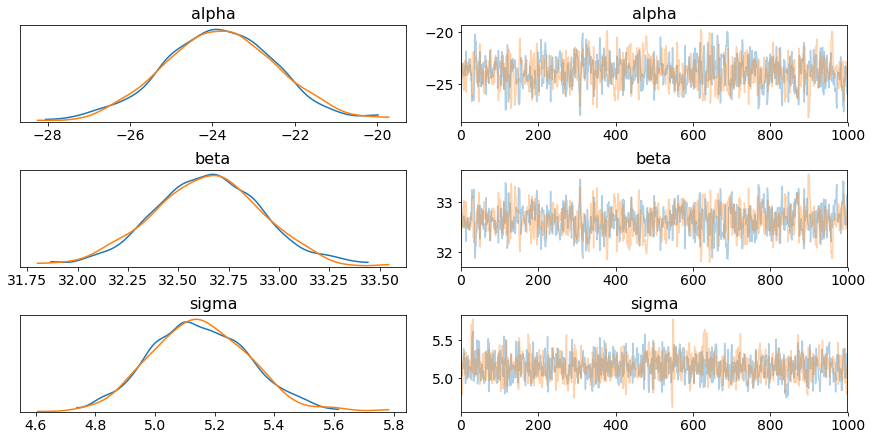

In [40]:
varnames = ['alpha', 'beta', 'sigma']
pm.traceplot(traceLog, varnames);

chainLog = traceLog[100:]

Interpretation (from https://socialsciences.mcmaster.ca/jfox/.Materials/Ch-4.html):

a=−23.79 : Isn’t directly interpretable since 0 on the log2 scale correspond to a weight of 1 kg (and, of course, height can’t be negative).

b=32.63 : Doubling weight is associated on average with an increase of about 33 cm of height.

σ=5.13 : On average the points are about 5 cm from the fitted regression.

In [41]:
weight_seq = np.arange(round(d.weight.min()), d.weight.max()+1)
# Given- that we have a lot of samples we can use less of them for plotting (or we can use all!)
#chain_N_thinned = chainLog[::10]
chain_N_thinned = chainLog
mu_pred = np.zeros((len(weight_seq), len(chain_N_thinned)*chainLog.nchains))
for i, w in enumerate(weight_seq):
    mu_pred[i] = chain_N_thinned['alpha'] + (chain_N_thinned['beta'] * np.log2(w))

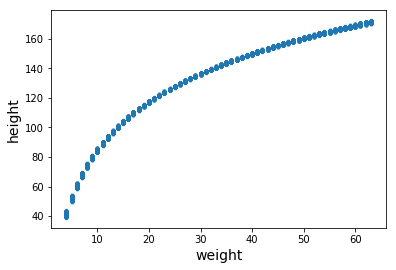

In [42]:
plt.plot(weight_seq, mu_pred, 'C0.', alpha=0.1)
plt.xlabel('weight', fontsize=14)
plt.ylabel('height', fontsize=14);

In [43]:
mu_mean = mu_pred.mean(1)
mu_hpd = pm.hpd(mu_pred.T, alpha=.03)

In [44]:
#height_pred = pm.sample_ppc(chain_N, num, m_N)
height_pred = pm.sample_posterior_predictive(chainLog, 200, logModel)
height_pred_hpd = pm.hpd(height_pred['height'], alpha=.03)

100%|██████████| 200/200 [00:00<00:00, 1243.64it/s]


In [45]:
idx = np.argsort(d.weight.values[:])
d_weight_ord = d.weight.values[:][idx]
height_pred_hpd = height_pred_hpd[idx]

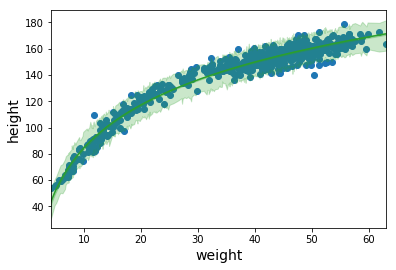

In [46]:
plt.scatter(d.weight[:], d.height[:])
plt.fill_between(weight_seq, mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.25)
plt.plot(weight_seq, mu_mean, 'C2')
#plt.plot(d.weight, map['mu'])
plt.fill_between(d_weight_ord, height_pred_hpd[:,0], height_pred_hpd[:,1], color='C2', alpha=0.25)
plt.xlabel('weight', fontsize=14)
plt.ylabel('height', fontsize=14)
plt.xlim(d.weight[:].min(), d.weight[:].max());